# Financial Applications of Gaussian Processes

In this notebook, we will learn about some of the financial applications of the Gaussian Process. We will look at optimizing a stock portfolio with the Black-Litterman Model using Gaussian Process Regression. The Black-Litterman model developed by Fischer Black and Robert Litterman at Goldman Sachs in the early 1990s is a portfolio optimization tool that combines market equilibrium with subjective investor views to generate diverse and stable portfolios compared to mean-variance optimization. Basically rather than using a stock's historical performance alone to determine how much to invest, this model allows us to factor in our beliefs on how a stock will perform and how confident we are on that prediction into our portfolio optimization. The model starts with the assumption that the market is at equilibrium (prior) before incorporating investor belief. In this notebook, we will implement the Black-Litterman model to create an optimal portfolio for a set of stocks while providing an overview on financial vocabulary.

References:

- [Black-Litterman Portfolio Optimization Using Gaussian Process Regression Li et all](https://www.iaeng.org/IJAM/issues_v53/issue_4/IJAM_53_4_34.pdf)

By: Thierno Diallo

Useful Libraries

In [1]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 16.0 MB/s eta 0:00:00


In [2]:
# Plotting and data processing
import numpy as np
import pandas as pd
import yfinance as yf

# Gaussian Process
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# Portfolio Optimization
from pypfopt import BlackLittermanModel, risk_models, expected_returns, black_litterman
from pypfopt.efficient_frontier import EfficientFrontier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


## Data Preperation

Here we will load the historical price data of a set of stocks using the Yahoo Finance API. We will use the **adjusted closing price**s rather than the regular closing price data. We use the adjusted closing price because it takes into account dividends, stock splits, and new stock offerings, whereas the closing price only reflects the last price at which the stock was traded. Therefore, when trying to understand returns on investments, the adjusted closing price is more accurate. For example, if a company pays \$5 in dividends and the stock price drops from \$100 to \$95, then using the closing price, the investor would appear to have lost \$5 and experienced a -5% return. However, the true return would be 0% since they gained \$5 in dividends. For financial modeling, we use stock returns rather than prices as that is a stronger indicator of how a stock is performing and here we care about performance. returns also have other nice properties such as being stationary.

In [3]:
stocks = ["AAPL","MSFT","GOOG","NVDA","GS","JPM","BA", "AMZN", "DIS"]
prices = yf.download(stocks, start="2010-01-01", end="2024-01-01", auto_adjust=False)['Adj Close']

# Grab monthly returns
returns = prices.resample('ME').last().pct_change().dropna()

# TODO: Why would we use monthly returns instead of daily?

[*********************100%***********************]  9 of 9 completed


Below, we explore the data to give you an idea of what time series data looks like here.

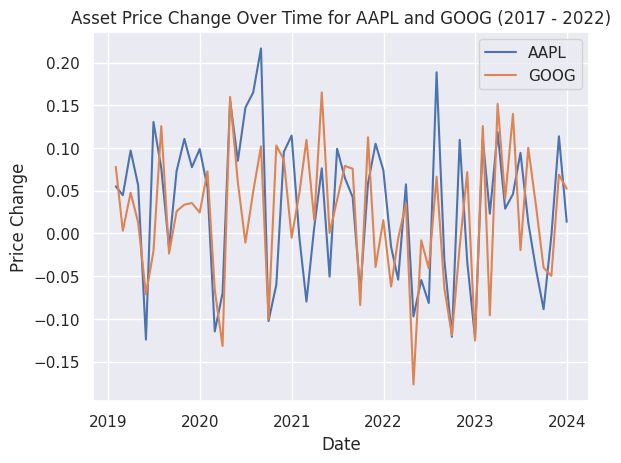

In [4]:
plt.plot(returns.loc['2019-01-01':'2024-01-01'][['AAPL', 'GOOG']])
plt.title('Asset Price Change Over Time for AAPL and GOOG (2017 - 2022)')
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.legend(['AAPL', 'GOOG'])
plt.show()

Below we look at the distribution of the data

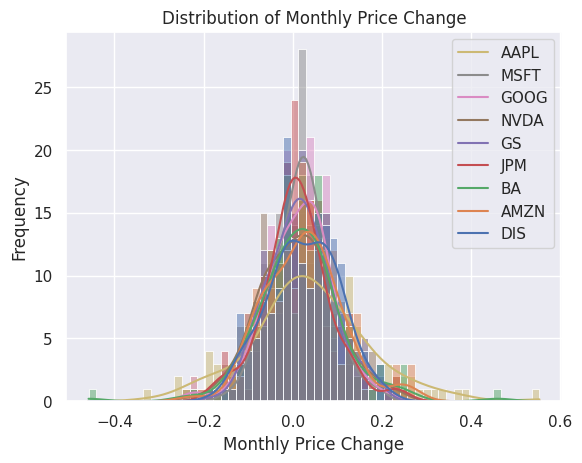

In [5]:
sns.histplot(returns, kde=True)
plt.title('Distribution of Monthly Price Change')
plt.xlabel('Monthly Price Change')
plt.ylabel('Frequency')
plt.legend(stocks)
plt.show()

#TODO: What can we tell about the distribution of our data? Why is this significant?

## Priors and Data Processing

The Black-Litterman portfolio assumes that the market is at equilibrium; therefore, we will calculate that prior here. **Market Equilibrium** occurs when fluctuations between supply and demand balance out, keeping prices relatively stable — meaning that for a given asset/stock, the number of shares that investors want to buy and sell are equal. At equilibrium, all public information is reflected in the asset price, meaning that no additional information will cause any investor to change their decision to buy or sell an asset. The resulting portfolio is known as the **Market Portfolio**. This theoretical portfolio considers all investable assets/stocks, weighted by their **Market Capitalization**, which is simply the number of outstanding shares an asset has multiplied by its public market price per share. To understand this weighting, consider the following: if Apple has a market cap of \$$2.5$ trillion and Microsoft has a market cap of \$500 billion, Apple would receive five times the weight of Microsoft in the market portfolio. In practice, since it's impossible to cosider every asset in the world, we approximate the market portfolio using a large and diversified index like the S&P 500 (an index representing the performance of 500 large-cap U.S. stocks) or shrink our world to only the assets we're considering. Here, we will use the S&P 500 as a proxie because it includes many of the major stocks and it's commonly used as the market portfolio in financial analyis.


[*********************100%***********************]  1 of 1 completed


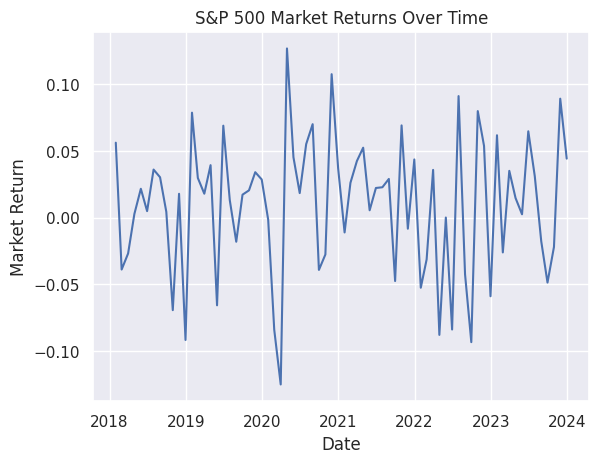

In [12]:
#TODO: grab ^GSPC returns for our period and visualize the time series
mrkt_price = yf.download('^GSPC', start="2010-01-01", end="2024-01-01", auto_adjust=False)['Adj Close']
mrkt_returns = mrkt_price.resample('ME').last().pct_change().dropna()
plt.plot(mrkt_returns.loc['2018-01-01':'2024-01-01'])
plt.title('S&P 500 Market Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Market Return')
plt.show()

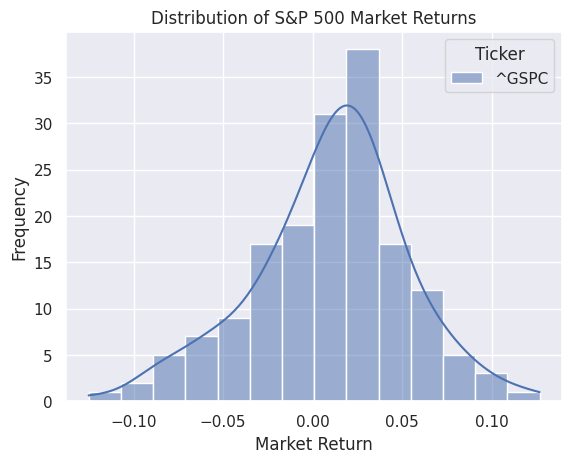

In [13]:
#TODO: Plot the distribution of returns
sns.histplot(mrkt_returns, kde=True)
plt.title('Distribution of S&P 500 Market Returns')
plt.xlabel('Market Return')
plt.ylabel('Frequency')
plt.show()

Below we compare the performance of the index and our idividually selected stocks. As you can see, on avergae the stocks yield higher returns than the index however, they are more volalite, having higher variance, than the index making them riskier whereas the index is safer investments. This risk is why many samll time investors invest in index funds.

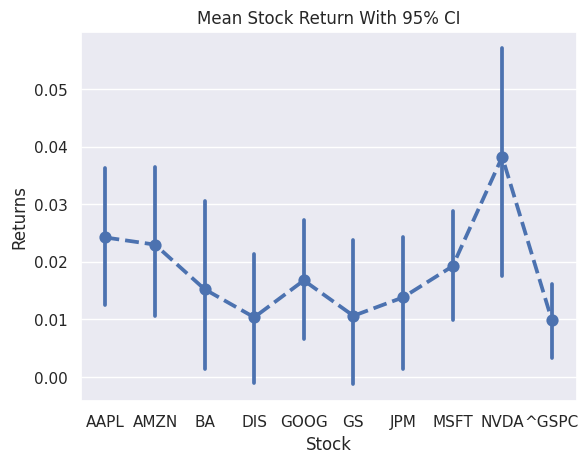

In [14]:
sns.pointplot(pd.concat([returns, mrkt_returns]), linestyles='--',
    markers='o')
plt.title('Mean Stock Return With 95% CI')
plt.xlabel('Stock')
plt.ylabel('Returns')
plt.show()

We will split our stocks into risky/volatile stocks, relative to the market, sto get a better understand of them. The volatility of a stock relative to market is measured as:

$$
\beta_i = \frac{\text{Cov}(r_i, r_M)}{\sigma^2_M}
$$

Where:

* $r_i$ is the return series of individual stock $i$
* $r_M$ is the return series of the **market portfolio**
* $\sigma^2_M$ is the variance of the market returns

β >1 means the stock has
higher volatility than the market, while β <1 indicates the
stock has lower volatility than the benchmark

In [15]:
#TODO: Split stocks into low and high volatility. The lists should
# contain stock names.
rM = mrkt_returns['^GSPC']
sigmaM = mrkt_returns.var()

low_beta = []
high_beta = []

for i in stocks:
  ri = returns[i]
  B_i = ri.cov(rM)/sigmaM
  if B_i.iloc[0] > 1:
    high_beta.append(i)
  else:
    low_beta.append(i)

In [16]:
low_beta

['MSFT']

In [17]:
high_beta

['AAPL', 'GOOG', 'NVDA', 'GS', 'JPM', 'BA', 'AMZN', 'DIS']

The priors of the Black-Litterman model are the expected returns under the market portfolio. Basically, assuming you had the optimal market portfolio, what are your expected future returns. These returns can be predicted using the **Capital Asset Pricing Model** which states that under the market portfolio, the thoeretical expected future returns considering asset risk and the market's risk-free rate is $\Pi$ such that:

$$
\Pi = \tau \Sigma w_{mkt}
$$

Where:

* $\Sigma$: the covariance matrix of asset returns (estimated from data)
* $w_{mkt}$: the **weights** of each stock in the market (i.e % of market cap)
* $\tau$: **risk aversion coefficient** (how much return investors demand per unit of risk)

Here $\Pi$ is a "theoretical" return vector representing what **must be true** for the market to be optimal.

In [18]:
market_caps = {t: yf.Ticker(t).info["marketCap"] for t in stocks}
tau = black_litterman.market_implied_risk_aversion(mrkt_price)

#TODO: Calculate theoretical returns
sigma = returns.cov()

w_mkt = pd.Series(market_caps).loc[stocks]
w_mkt = w_mkt / w_mkt.sum()

pi = tau * sigma.dot(w_mkt)

Let's plot our prior to see our theoretical returns under the market portfolio. Also, we examine the weights of each stock in our portfolio. We start by visualizing the market weights.

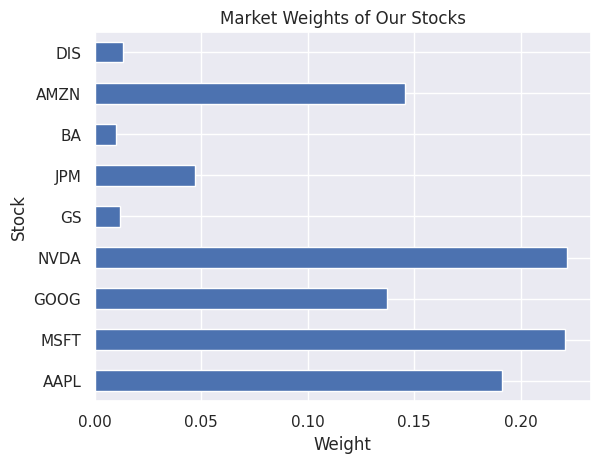

In [19]:
# Visualize market weights
w_mkt.plot.barh()
plt.title('Market Weights of Our Stocks')
plt.xlabel('Weight')
plt.ylabel('Stock')
plt.show()

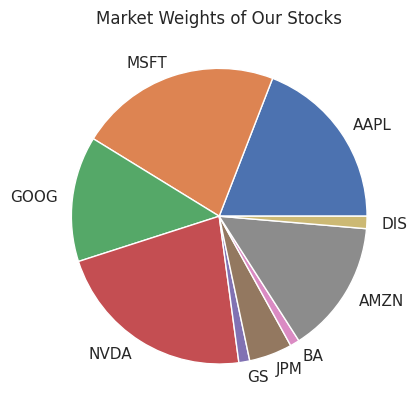

In [20]:
w_mkt.plot.pie()
plt.title('Market Weights of Our Stocks')
plt.show()

Next, we visualize the expected returns under the market portfolio for the next time period.

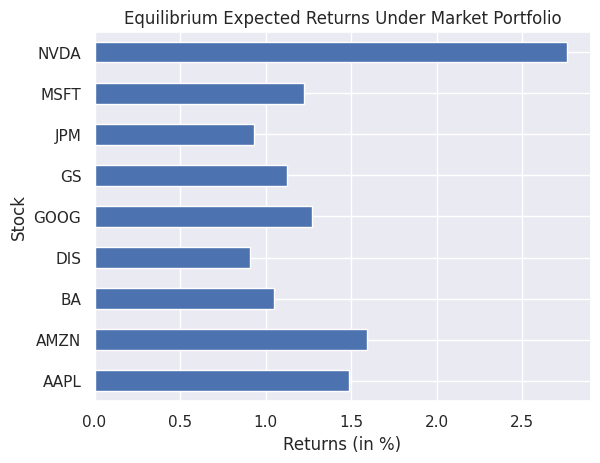

In [21]:
(pi * 100).plot.barh()
plt.title('Equilibrium Expected Returns Under Market Portfolio')
plt.xlabel('Returns (in %)')
plt.ylabel('Stock')
plt.show()

## Gaussian Process to Generate “Investor Views”

In this secion we will generate investor views using Gaussian Process Regression to make predections of each asset's future monthly returns. These will serve as our views. Then using the covariance matrix of regression to construct a confidence level on our views using the following as the the paper suggests:

$$
v_i = 50\% + \frac{1/s_i}{\sum_j (1/s_j)}
$$

Here is a fun too to help you build your GPR kernel: https://smlbook.org/GP/

In [22]:
#TODO: Implment gausian process regression give a stock's historic returns
def GPR(stock):
  y = stock.values
  X = np.arange(len(stock.values)).reshape(-1, 1)

  kernel = C(1.0, (1e-3,1e3)) * RBF(1, (1e-3,1e3))
  gpr = GaussianProcessRegressor(kernel=kernel,
                                  alpha=1e-5,
                                  normalize_y=True)
  gpr.fit(X, y)
  next_period = np.arange(len(stock.values) + 1).reshape(-1, 1)
  mu, std = gpr.predict(next_period, return_std=True)
  return mu[-1], std[-1]

#TODO: Using GPR generate views alongside the confidence on each view as defined above
def GenerateViews(univ):
  views_dict = {}
  confidence = []
  stds = []

  for stock in univ:
    mu, std = GPR(returns[stock])
    views_dict[stock] = mu
    confidence.append(1/std)
    stds.append(std)

  confidence = 0.5 + confidence / sum(confidence)

  return views_dict, confidence, stds

In [24]:
GenerateViews(stocks)

({'AAPL': np.float64(0.024222023389674902),
  'MSFT': np.float64(0.01923453098183717),
  'GOOG': np.float64(0.01675921036520131),
  'NVDA': np.float64(0.03823371597251002),
  'GS': np.float64(0.010611687369328257),
  'JPM': np.float64(0.013813192698310835),
  'BA': np.float64(0.015229318628838747),
  'AMZN': np.float64(0.022982221119768616),
  'DIS': np.float64(0.010353063172449122)},
 array([0.61478669, 0.64436066, 0.62684074, 0.56905072, 0.6079924 ,
        0.62202556, 0.59180212, 0.60323843, 0.61990267]),
 [np.float64(0.07854686393201248),
  np.float64(0.06245562005532795),
  np.float64(0.07108232480648255),
  np.float64(0.13057263386358242),
  np.float64(0.08348860129939105),
  np.float64(0.07388726656707285),
  np.float64(0.09821270910690368),
  np.float64(0.08733312226345874),
  np.float64(0.0751954485627011)])

Let's take a look at the views generated by the gaussian process for the high votality stocks.

In [23]:
q, v, s = GenerateViews(stocks)

df = pd.DataFrame({
    'Stock':    stocks,
    'Prediction':      q.values(),
    'stdev':       s,
    'View Confidence': [f'{val:.2f}%' for val in v * 100]
})

display(df)


,Stock,Prediction,stdev,View Confidence
0,AAPL,0.024222,0.078547,61.48%
1,MSFT,0.019235,0.062456,64.44%
2,GOOG,0.016759,0.071082,62.68%
3,NVDA,0.038234,0.130573,56.91%
4,GS,0.010612,0.083489,60.80%
5,JPM,0.013813,0.073887,62.20%
6,BA,0.015229,0.098213,59.18%
7,AMZN,0.022982,0.087333,60.32%
8,DIS,0.010353,0.075195,61.99%


Notice that these predictions are low as we are looking at monthly time steps meaning only expected returns for the next month

 ## Black-Litterman Model using GPR

 In this section, we will create our Black-Litterman models using GPR and look at the resulting portfolio and returns

In [45]:
#TODO: Complete implementation of the Black-Litterman Model using GPR views and confidence
def BLGP(univ, sigma, pi):
  views, confidence, _ = GenerateViews(univ)
  bl = BlackLittermanModel(sigma, pi=pi, absolute_views=views, omega="idzorek", view_confidences=confidence)
  return bl

We being by examining the optimal portfolio when we create our portfolio considering GPR views

In [46]:
prices_actual = yf.download(stocks, start="2024-01-01", end="2024-03-01", auto_adjust=False)['Adj Close']

# Grab monthly returns
returns_actual = prices_actual.resample('ME').last().pct_change().dropna()
returns_actual = returns_actual[stocks].iloc[0]

[*********************100%***********************]  9 of 9 completed


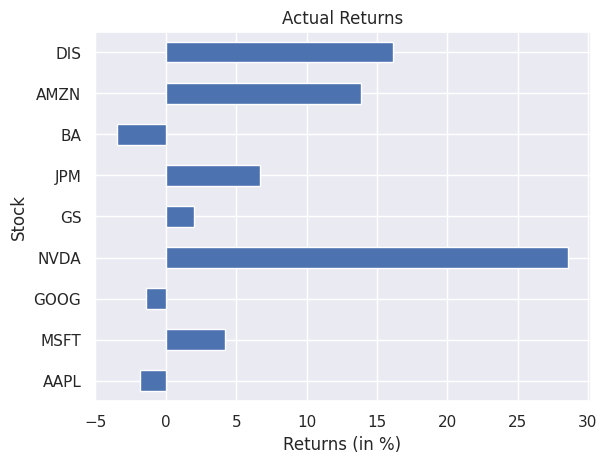

In [47]:
(returns_actual * 100).plot.barh()
plt.title('Actual Returns')
plt.xlabel('Returns (in %)')
plt.ylabel('Stock')
plt.show()

In [ ]:
bl = BLGP(stocks, sigma, pi)
bl_w = pd.Series({stock: bl.bl_weights()[stock] for stock in stocks})
bl_r = pd.Series({stock: bl.bl_returns()[stock] for stock in stocks})

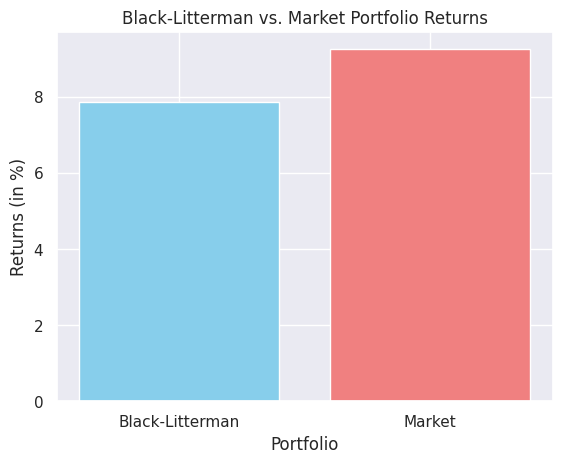

In [49]:
bl_ret = np.dot(bl_w, returns_actual)
mk_ret = np.dot(w_mkt, returns_actual)
plt.bar(['Black-Litterman', 'Market'], [bl_ret * 100, mk_ret * 100], color=['skyblue', 'lightcoral'])
plt.title('Black-Litterman vs. Market Portfolio Returns')
plt.xlabel('Portfolio')
plt.ylabel('Returns (in %)')
plt.show()

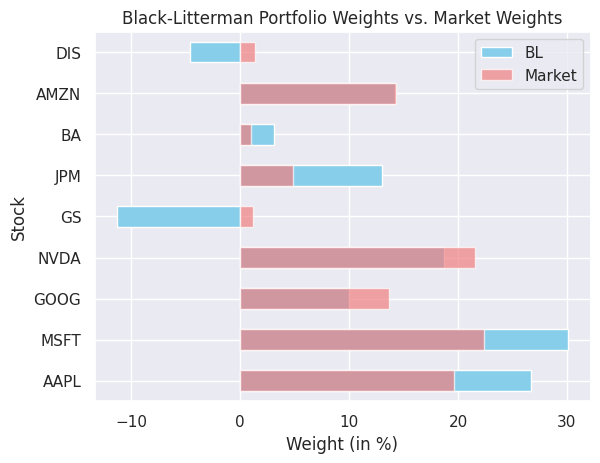

In [ ]:
# What does our weights under BL model look like
(bl_w * 100).plot.barh( color='skyblue')
(w_mkt * 100).plot.barh(color='lightcoral', alpha=0.7)
plt.title('Black-Litterman Portfolio Weights vs. Market Weights')
plt.xlabel('Weight (in %)')
plt.ylabel('Stock')
plt.legend(['BL', 'Market'])
plt.show()

#Negative here means we should short that stock

##Challenge

If the market outperfomed you, can you try to get closer to it or beat it

In [ ]:
#TODO